In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Prepare and normalize structural features"""
    # Extract SASA
    sasa = df['sasa'].values.reshape(-1, 1)
    
    # Convert string arrays to numerical arrays for angles
    phi_small = np.array([eval(x) for x in df['phi_small']])
    psi_small = np.array([eval(x) for x in df['psi_small']])
    
    # Convert secondary structure to one-hot encoding
    ss = np.column_stack((df['E'], df['H'], df['L']))
    
    # Normalize SASA and angles
    scaler_sasa = StandardScaler()
    sasa_normalized = scaler_sasa.fit_transform(sasa)
    
    scaler_phi = StandardScaler()
    phi_normalized = scaler_phi.fit_transform(phi_small)
    
    scaler_psi = StandardScaler()
    psi_normalized = scaler_psi.fit_transform(psi_small)
    
    return sasa_normalized, phi_normalized, psi_normalized, ss

In [5]:
def create_sequence_model():
   """Create CNN model for sequence data"""
   seq_input = tf.keras.layers.Input(shape=(33,))
   x = tf.keras.layers.Embedding(21, 21)(seq_input)
   x = tf.keras.layers.Reshape((33, 21, 1))(x)
   x = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
   x = tf.keras.layers.Flatten()(x)
   seq_features = tf.keras.layers.Dense(32, activation='relu')(x)
   
   return tf.keras.Model(inputs=seq_input, outputs=seq_features)

In [6]:
def create_structure_model():
    """Create model for structural features"""
    # SASA input
    sasa_input = tf.keras.layers.Input(shape=(1,))
    sasa_features = tf.keras.layers.Dense(8, activation='relu')(sasa_input)
    
    # Angles input
    phi_input = tf.keras.layers.Input(shape=(3,))  # 3 phi angles
    psi_input = tf.keras.layers.Input(shape=(3,))  # 3 psi angles
    angles_concat = tf.keras.layers.Concatenate()([phi_input, psi_input])
    angles_features = tf.keras.layers.Dense(16, activation='relu')(angles_concat)
    
    # Secondary structure input
    ss_input = tf.keras.layers.Input(shape=(3,))
    ss_features = tf.keras.layers.Dense(8, activation='relu')(ss_input)
    
    # Combine all structural features
    combined = tf.keras.layers.Concatenate()([sasa_features, angles_features, ss_features])
    struct_features = tf.keras.layers.Dense(32, activation='relu')(combined)
    
    return tf.keras.Model(
        inputs=[sasa_input, phi_input, psi_input, ss_input],
        outputs=struct_features
    )

In [7]:
def create_ensemble_model():
    """Create ensemble model combining sequence and structure"""
    # Sequence branch
    seq_input = tf.keras.layers.Input(shape=(33,))
    seq_model = create_sequence_model()
    seq_features = seq_model(seq_input)
    
    # Structure branch
    sasa_input = tf.keras.layers.Input(shape=(1,))
    phi_input = tf.keras.layers.Input(shape=(3,))
    psi_input = tf.keras.layers.Input(shape=(3,))
    ss_input = tf.keras.layers.Input(shape=(3,))
    
    struct_model = create_structure_model()
    struct_features = struct_model([sasa_input, phi_input, psi_input, ss_input])
    
    # Combine features
    combined = tf.keras.layers.Concatenate()([seq_features, struct_features])
    
    # Final dense layers
    x = tf.keras.layers.Dense(64, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(
        inputs=[seq_input, sasa_input, phi_input, psi_input, ss_input],
        outputs=output
    )

In [8]:
def train_and_evaluate():
   # Load data
   print("Loading data...")
   train_df = pd.read_csv("../new/processed_data_train.csv")
   test_df = pd.read_csv("../new/processed_data_test.csv")
   
   # Shuffle both training and test data
   print("Shuffling data...")
   train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
   test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
   
   # Print class distribution
   print("\nTraining set distribution:")
   print(train_df['label'].value_counts())
   print("\nTest set distribution:")
   print(test_df['label'].value_counts())
   
   # Prepare data
   print("\nPreparing data...")
   X_train_seq = prepare_sequence_data(train_df)
   X_test_seq = prepare_sequence_data(test_df)

   X_train_sasa, X_train_phi, X_train_psi, X_train_ss = prepare_structure_data(train_df)
   X_test_sasa, X_test_phi, X_test_psi, X_test_ss = prepare_structure_data(test_df)
    
   
   y_train = train_df['label'].values
   y_test = test_df['label'].values
   
   print(f"\nTraining sequence data shape: {X_train_seq.shape}")
   print(f"Training SASA data shape: {X_train_sasa.shape}")
   print(f"Training SS data shape: {X_train_ss.shape}")
   
   # Calculate class weights
   total_samples = len(y_train)
   pos_samples = np.sum(y_train == 1)
   neg_samples = np.sum(y_train == 0)
   
   class_weights = {
       0: total_samples / (2 * neg_samples),
       1: total_samples / (2 * pos_samples)
   }
   
   print("\nClass weights:", class_weights)
   
   # Initialize cross-validation
   kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
   
   # Initialize metrics storage
   metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
   test_predictions = []
   
   # Cross-validation loop
   for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
       print(f"\nFold {fold}/5")
       
       # Create callbacks
       early_stopping = tf.keras.callbacks.EarlyStopping(
           monitor='val_loss',
           patience=5,
           restore_best_weights=True
       )
       
       # Create and compile model
       model = create_ensemble_model()
       model.compile(
           optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
           loss='binary_crossentropy',
           metrics=['accuracy']
       )
       
        # Prepare fold data
       train_data = [
        X_train_seq[train_idx],
        X_train_sasa[train_idx],
        X_train_phi[train_idx],
        X_train_psi[train_idx],
        X_train_ss[train_idx]
    ]
       val_data = [
        X_train_seq[val_idx],
        X_train_sasa[val_idx],
        X_train_phi[val_idx],
        X_train_psi[val_idx],
        X_train_ss[val_idx]
    ]
       
       # Train model
       print("Training model...")
       history = model.fit(
           train_data, y_train[train_idx],
           batch_size=32,
           epochs=50,
           validation_data=(val_data, y_train[val_idx]),
           callbacks=[early_stopping],
           class_weight=class_weights,
           verbose=1
       )
       
       # Plot training history
       plt.figure(figsize=(10, 6))
       plt.plot(history.history['accuracy'], label='Train Accuracy')
       plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
       plt.title(f'Model Accuracy - Fold {fold}')
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy')
       plt.legend()
       plt.show()
       
       # Evaluate on validation set
       y_pred = model.predict(val_data)
       y_pred_binary = (y_pred > 0.5).astype(int)
       
       # Calculate metrics
       cm = confusion_matrix(y_train[val_idx], y_pred_binary)
       metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
       metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
       metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
       metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
       metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
       
       # Predict on test set
       test_pred = model.predict([X_test_seq, X_test_sasa, X_test_phi, X_test_psi, X_test_ss])
       test_predictions.append(test_pred)
       
       print(f"\nFold {fold} Results:")
       print(f"Accuracy: {metrics['acc'][-1]:.4f}")
       print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
       print(f"MCC: {metrics['mcc'][-1]:.4f}")
       print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
       print(f"Specificity: {metrics['sp'][-1]:.4f}")
   
   # Print average cross-validation results
   print("\nAverage Cross-validation Results:")
   for metric in metrics:
       print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
   
   # Ensemble predictions on test set
   test_pred_avg = np.mean(test_predictions, axis=0)
   test_pred_binary = (test_pred_avg > 0.5).astype(int)
   
   # Calculate final test metrics
   cm_test = confusion_matrix(y_test, test_pred_binary)
   test_balanced_acc = balanced_accuracy_score(y_test, test_pred_binary)
   
   print("\nFinal Test Set Results:")
   print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
   print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
   print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
   print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
   print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
   print("Confusion Matrix:")
   print(cm_test)
   
   return model

Loading data...
Shuffling data...

Training set distribution:
label
1    4591
0    4259
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Preparing data...

Training sequence data shape: (8850, 33)
Training SASA data shape: (8850, 1)
Training SS data shape: (8850, 3)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5


2024-11-26 22:50:34.523625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-26 22:50:34.523706: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-26 22:50:34.523717: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-26 22:50:34.523965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 22:50:34.523983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...
Epoch 1/50


2024-11-26 22:50:36.023277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.5073 - loss: 0.6970 - val_accuracy: 0.5492 - val_loss: 0.6878
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.5339 - loss: 0.6897 - val_accuracy: 0.5492 - val_loss: 0.6874
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5443 - loss: 0.6860 - val_accuracy: 0.5582 - val_loss: 0.6848
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5803 - loss: 0.6701 - val_accuracy: 0.6949 - val_loss: 0.5902
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7190 - loss: 0.5592 - val_accuracy: 0.7311 - val_loss: 0.5475
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7551 - loss: 0.5134 - val_accuracy: 0.7328 - val_loss: 0.5365
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7775 - loss: 0.4852 - val_accuracy: 0.7243 - val_loss: 0.5403
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7805 - loss: 0.4720 - val_accurac

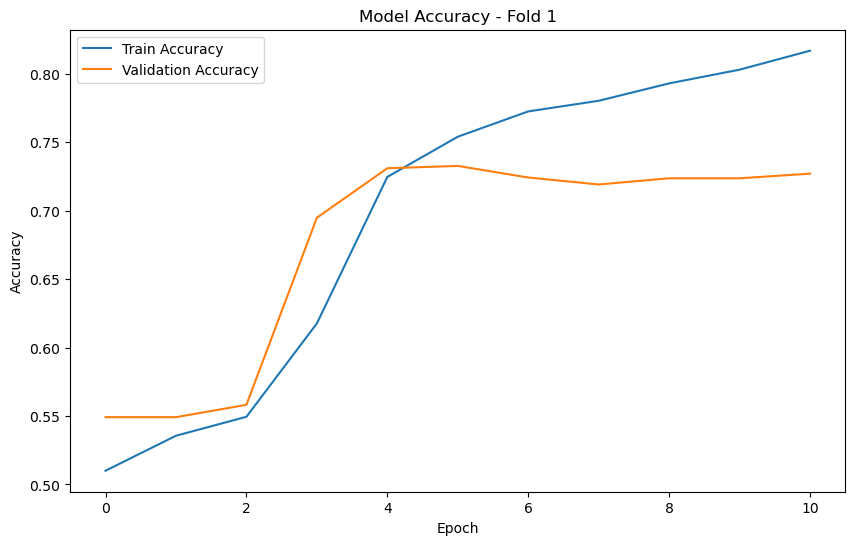

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Fold 1 Results:
Accuracy: 0.7328
Balanced Accuracy: 0.7266
MCC: 0.4588
Sensitivity: 0.7956
Specificity: 0.6576

Fold 2/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5092 - loss: 0.6964 - val_accuracy: 0.5593 - val_loss: 0.6863
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5595 - loss: 0.6815 - val_accuracy: 0.6305 - val_loss: 0.6431
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6566 - loss: 0.6318 - val_accuracy: 0.6621 - val_loss: 0.6137
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6942 - loss: 0.5952 - val_accuracy: 0.6836 - val_loss: 0.5914
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7273 - loss: 0.5591 - val_accuracy: 0.7158 - val_loss: 0.5600
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7544 - loss: 0.5206 - val_accuracy: 0.7288 - val_loss: 0.5414
E

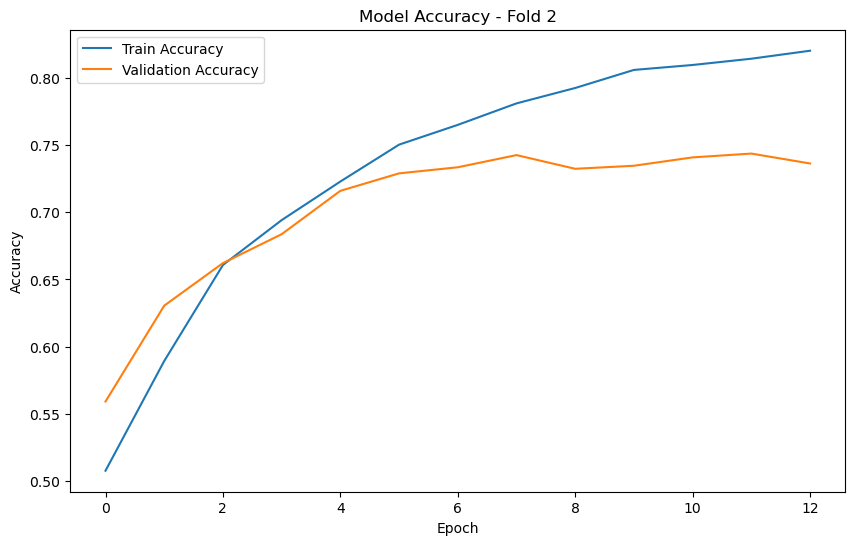

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 2 Results:
Accuracy: 0.7424
Balanced Accuracy: 0.7347
MCC: 0.4873
Sensitivity: 0.8574
Specificity: 0.6120

Fold 3/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5141 - loss: 0.6951 - val_accuracy: 0.5486 - val_loss: 0.6876
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5959 - loss: 0.6670 - val_accuracy: 0.6480 - val_loss: 0.6229
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6979 - loss: 0.5949 - val_accuracy: 0.7034 - val_loss: 0.5701
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7334 - loss: 0.5450 - val_accuracy: 0.7299 - val_loss: 0.5350
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7557 - loss: 0.5126 - val_accuracy: 0.7305 - val_loss: 0.5405
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7730 - loss: 0.4933 - val_accuracy: 0.7350 - val_loss: 0.5244
E

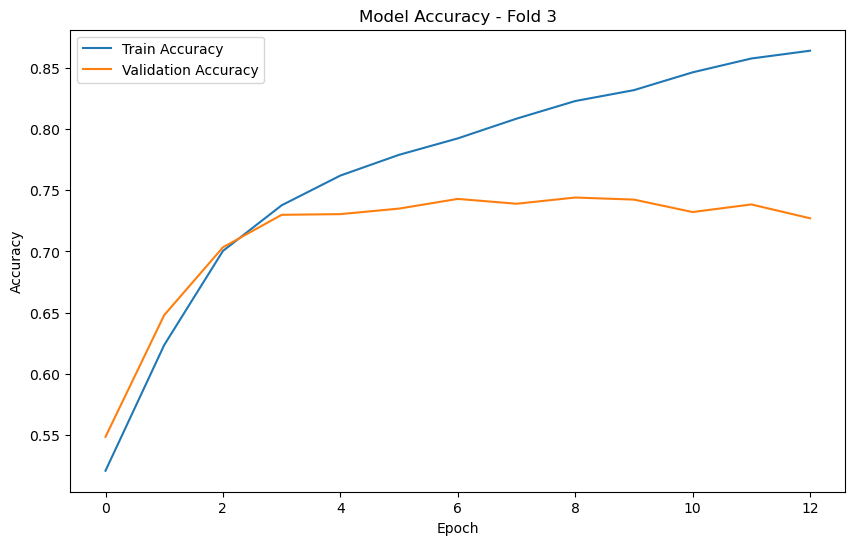

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 3 Results:
Accuracy: 0.7390
Balanced Accuracy: 0.7381
MCC: 0.4867
Sensitivity: 0.8399
Specificity: 0.6363

Fold 4/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.5038 - loss: 0.6952 - val_accuracy: 0.5452 - val_loss: 0.6858
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6137 - loss: 0.6563 - val_accuracy: 0.7164 - val_loss: 0.5688
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7270 - loss: 0.5581 - val_accuracy: 0.7186 - val_loss: 0.5458
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7452 - loss: 0.5233 - val_accuracy: 0.7249 - val_loss: 0.5362
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7591 - loss: 0.4970 - val_accuracy: 0.7401 - val_loss: 0.5240
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.7784 - loss: 0.4769 - val_accuracy: 0.7254 - val_loss: 0.5400
E

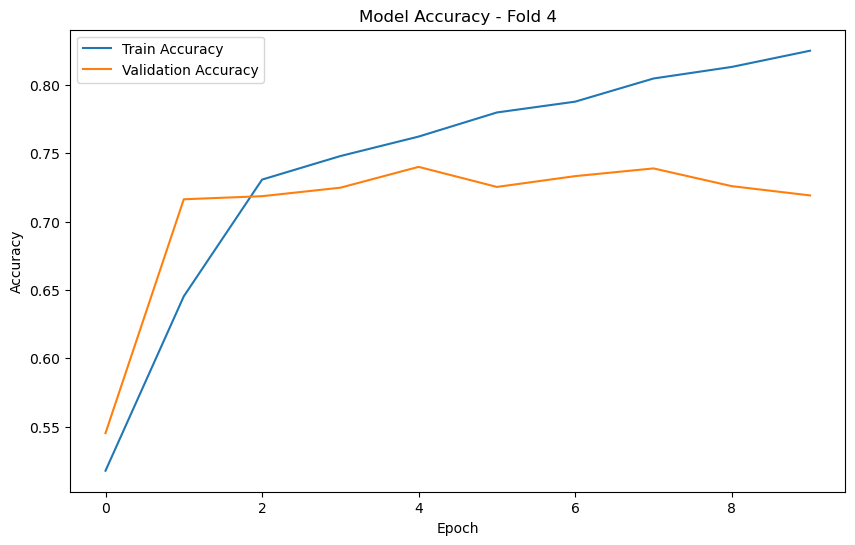

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 4 Results:
Accuracy: 0.7401
Balanced Accuracy: 0.7407
MCC: 0.4887
Sensitivity: 0.8282
Specificity: 0.6532

Fold 5/5
Training model...
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5049 - loss: 0.6941 - val_accuracy: 0.5452 - val_loss: 0.6884
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5616 - loss: 0.6814 - val_accuracy: 0.6718 - val_loss: 0.6118
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6940 - loss: 0.5926 - val_accuracy: 0.7254 - val_loss: 0.5479
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7380 - loss: 0.5346 - val_accuracy: 0.7407 - val_loss: 0.5334
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7561 - loss: 0.5044 - val_accuracy: 0.7424 - val_loss: 0.5345
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7709 - loss: 0.4884 - val_accuracy: 0.7362 - val_loss: 0.5338
Epo

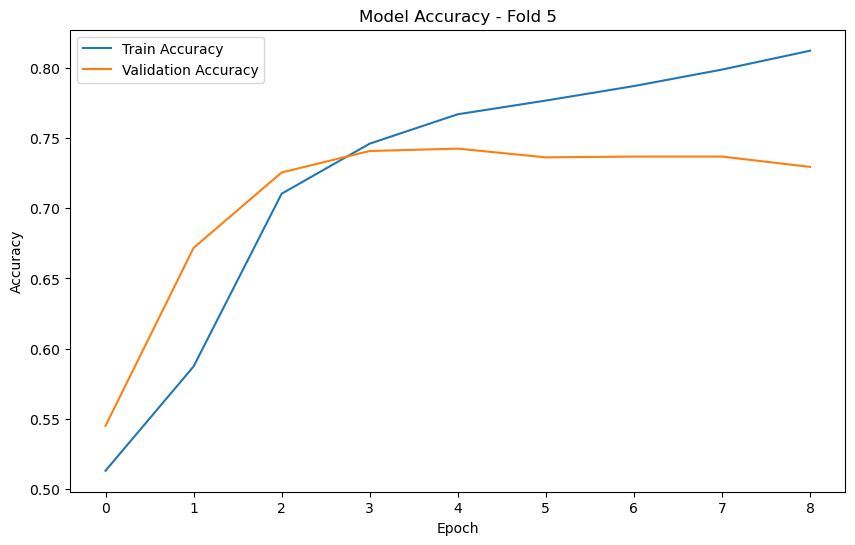

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 5 Results:
Accuracy: 0.7407
Balanced Accuracy: 0.7401
MCC: 0.4806
Sensitivity: 0.7563
Specificity: 0.7240

Average Cross-validation Results:
ACC: 0.7390 ± 0.0033
BALANCED_ACC: 0.7361 ± 0.0052
MCC: 0.4804 ± 0.0112
SN: 0.8155 ± 0.0358
SP: 0.6566 ± 0.0373

Final Test Set Results:
Accuracy: 0.6737
Balanced Accuracy: 0.7421
MCC: 0.2817
Sensitivity: 0.8250
Specificity: 0.6592
Confusion Matrix:
[[1646  851]
 [  42  198]]


In [9]:
if __name__ == "__main__":
    model = train_and_evaluate()